## Developed by: Saad Aldin Mohamed
## email: sa3danny@yahoo.com

In [1]:
# Common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 4)

# Ignore useless warnings
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# ------------------------------------- Data preparation -------------------------------------------

In [2]:
activation_data = pd.read_excel('Activation_status_data.xlsx')
activation_data.head(3)

,name,activated,N2_BET,N2_Langmiur,last solvent,method
0,ACAJIZ_clean,yes,0.0,0.0,chloroform,exchange
1,ACAJOF_clean,yes,0.0,0.0,chloroform,exchange
2,ACUFEK_clean,yes,NaN,3800.0,dichloromethane,exchange


In [3]:
activation_data['activated'].unique()

array(['yes', nan, 'no', 'dup-remove', 'hypo-remove'], dtype=object)

In [4]:
## Remove duplicate and hypothetical enteries
dup_remove = activation_data[activation_data['activated']=='dup-remove'].index
hypo_remove = activation_data[activation_data['activated']=='hypo-remove'].index
activation_data = activation_data.drop(dup_remove)
activation_data = activation_data.drop(hypo_remove)

print ('Removed duplicate enteries = ', len(dup_remove))
print ('Removed hypothetical enteries = ', len(hypo_remove))
print ('size of the remaining data = ', len(activation_data))

Removed duplicate enteries =  49
Removed hypothetical enteries =  6
size of the remaining data =  280


# ----------------------------------    Geomterical Properties    ------------------------------------

In [5]:
geom_all = pd.read_csv("2019-11-01-ASR-public_12020.csv")
geom_data = geom_all[['filename', 'LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g', 'AV_VF', 'AV_cm3_g']]
geom_data = pd.DataFrame(geom_data)
geom_data.rename(columns = {'filename':'name'}, inplace=True)
geom_data.head(3)

,name,LCD,PLD,LFPD,cm3_g,ASA_m2_cm3,ASA_m2_g,AV_VF,AV_cm3_g
0,1499489-acs.cgd.6b01265_1499490_clean,10.85017,3.77263,10.26663,0.884188,1701.53,1924.40,0.6458,0.730388
1,ACECIV_ion_b,3.59910,2.94934,3.57968,2.601950,0.00,0.00,0.2312,0.088857
2,ACOCOM_clean,24.60642,13.03430,24.60642,0.349927,1537.41,4393.52,0.8630,2.466230


In [6]:
#Merge activation data with geometerical data
activation_geom = pd.merge(activation_data, geom_data, on = 'name', how = "inner" )
activation_geom.head(3)

,name,activated,N2_BET,N2_Langmiur,last solvent,method,LCD,PLD,LFPD,cm3_g,ASA_m2_cm3,ASA_m2_g,AV_VF,AV_cm3_g
0,ACAJIZ_clean,yes,0.0,0.0,chloroform,exchange,6.18650,5.74044,6.18650,1.301480,981.157,753.879,0.4824,0.370656
1,ACAJOF_clean,yes,0.0,0.0,chloroform,exchange,6.86398,6.10482,6.86398,1.218710,1121.270,920.046,0.5130,0.420936
2,ACUFEK_clean,yes,NaN,3800.0,dichloromethane,exchange,15.55627,9.00897,15.55627,0.559431,2205.120,3941.720,0.7870,1.406790


# ----------------------------------    Mechanical Properties    ------------------------------------

In [7]:
elastic = pd.read_csv("Elastic_properties_strain_1.0.csv")

In [8]:
#Round negative values to zero
columns = elastic.columns
for i in columns[1:]:
    negatives_ind = elastic[elastic[i]<0].index
    elastic.loc[negatives_ind, i] = 0

In [9]:
# Cacualte young modulus (Reuss and Voigt)
elastic['Ev'] = (9*elastic['Kv']*elastic['Gv'])/(3*elastic['Kv']+elastic['Gv'])
elastic['Er'] = (9*elastic['Kr']*elastic['Gr'])/(3*elastic['Kr']+elastic['Gr'])

# For some of cases; both Kr and Gr are zeros,
# therefore the estimated Er should be zero instead of 'nan'

elastic['Er'] = elastic['Er'].fillna(0);

In [10]:
#Calcualte average properties
elastic['K'] = (elastic['Kv']+elastic['Kr'])/2
elastic['G'] = (elastic['Gv']+elastic['Gr'])/2
elastic['E'] = (elastic['Ev']+elastic['Er'])/2

elastic.head(3)

,name,Kv,Kr,Gv,Gr,Ev,Er,K,G,E
0,ACAJIZ_clean,25.416,11.888,18.703,10.893,45.056914,25.033053,18.6520,14.798,35.044984
1,ACAJOF_clean,4.809,4.578,8.241,3.267,15.734900,7.917589,4.6935,5.754,11.826245
2,ACUFEK_clean,13.441,10.554,0.854,0.000,2.508865,0.000000,11.9975,0.427,1.254432


In [11]:
# For most of MOFs, the lower bound corresponds to that estimated with Reuss methods
# However, for very few cases; the lower bound was asscociated with Voigt method
# This probably due to instability of the crystal, or in-adequency of the forcefield or the adopted method.
# Indeed we have to remove these MOFs

ind = elastic[(elastic['Kr']>elastic['Kv'])|
                          (elastic['Gr']>elastic['Gv'])|
                          (elastic['Er']>elastic['Ev'])].index

elastic = elastic.drop(ind)

In [12]:
activation_geom_elastic = pd.merge(elastic, activation_geom, on = 'name', how = "inner" )
activation_geom_elastic.head(3)

,name,Kv,Kr,Gv,Gr,Ev,Er,K,G,E,...,last solvent,method,LCD,PLD,LFPD,cm3_g,ASA_m2_cm3,ASA_m2_g,AV_VF,AV_cm3_g
0,ACAJIZ_clean,25.416,11.888,18.703,10.893,45.056914,25.033053,18.6520,14.798,35.044984,...,chloroform,exchange,6.18650,5.74044,6.18650,1.301480,981.157,753.879,0.4824,0.370656
1,ACAJOF_clean,4.809,4.578,8.241,3.267,15.734900,7.917589,4.6935,5.754,11.826245,...,chloroform,exchange,6.86398,6.10482,6.86398,1.218710,1121.270,920.046,0.5130,0.420936
2,ACUFEK_clean,13.441,10.554,0.854,0.000,2.508865,0.000000,11.9975,0.427,1.254432,...,dichloromethane,exchange,15.55627,9.00897,15.55627,0.559431,2205.120,3941.720,0.7870,1.406790


# ------------------------------------ Last solvent ------------------------------------

In [13]:
activated_geom_elastic = activation_geom_elastic[(activation_geom_elastic['activated'] == 'yes')]
collapsed_geom_elastic = activation_geom_elastic[(activation_geom_elastic['activated'] == 'no')]

print ('Activated MOFs', len(activated_geom_elastic))
print ('collapsed MOFs', len(collapsed_geom_elastic))

Activated MOFs 170
collapsed MOFs 30


In [14]:
# Last solvent
activated_last_solvent = activated_geom_elastic.copy()
activated_last_solvent.reset_index(inplace = True)
activated_last_solvent['last solvent'].unique()

array(['chloroform', 'dichloromethane', 'CO2', 'methanol', 'acetone', nan,
       'mixture (water/DMA)', 'water', 'mixture (ethanol/water)',
       'acetonitrile', 'mixture (methanol/dichloromethane)', 'ethanol',
       'mixture (acetonitrile/DMF)', 'DMF', 'freeze',
       'mixture (dichloromethane/methanol)',
       'mixture (ethanol/DMF/water)', 'mixture (alcohol/water)',
       'mixture(water/methanol)', 'tetrahydrofuran',
       'mixture (methanol/water)', 'mixture (water/methanol)',
       'mixture(DMF/ethanol)', 'mixture(DMF/water)'], dtype=object)

In [15]:
# Last solvent
collapsed_last_solvent = collapsed_geom_elastic.copy()
collapsed_last_solvent.reset_index(inplace = True)
collapsed_last_solvent['last solvent'].unique()

array(['acetone', 'CO2', 'mixture (water/DMA)', 'DMF', 'many', 'freeze',
       'dichloromethane', nan, 'mixture (DMF/water)',
       'mixture (DMA/ethanol/water)', 'mixture(DMF/acetonitrile)'],
      dtype=object)

In [16]:
pd.options.mode.chained_assignment = None  # default='warn'

data = np.genfromtxt("Solvent_surface_tension_boiling_point.txt", skip_header = 1, dtype = "str")
solvent = data[:,0]
tension = data[:,1].astype("float") # mN/m
boiling = data[:,2].astype("float") # C

#------------------------------ activated MOFs --------------------------------------------#
activated_last_solvent['tension']=''
activated_last_solvent['boiling']=''

for i in range(0, len(activated_last_solvent)):
    sol = activated_last_solvent['last solvent'][i]
    if sol in solvent:
        ind = solvent.tolist().index(sol)
        activated_last_solvent['tension'][i] = tension[ind]
        activated_last_solvent['boiling'][i] = boiling[ind]
        
#------------------------------ collapsed MOFs --------------------------------------------#
collapsed_last_solvent['tension']=''
collapsed_last_solvent['boiling']=''

for i in range(0, len(collapsed_last_solvent)):
    sol = collapsed_last_solvent['last solvent'][i]
    if sol in solvent:
        ind = solvent.tolist().index(sol)
        collapsed_last_solvent['tension'][i] = tension[ind]
        collapsed_last_solvent['boiling'][i] = boiling[ind]
    
activated_last_solvent.head(3)


,index,name,Kv,Kr,Gv,Gr,Ev,Er,K,G,...,LCD,PLD,LFPD,cm3_g,ASA_m2_cm3,ASA_m2_g,AV_VF,AV_cm3_g,tension,boiling
0,0,ACAJIZ_clean,25.416,11.888,18.703,10.893,45.056914,25.033053,18.6520,14.798,...,6.18650,5.74044,6.18650,1.301480,981.157,753.879,0.4824,0.370656,27.1,61.2
1,1,ACAJOF_clean,4.809,4.578,8.241,3.267,15.734900,7.917589,4.6935,5.754,...,6.86398,6.10482,6.86398,1.218710,1121.270,920.046,0.5130,0.420936,27.1,61.2
2,2,ACUFEK_clean,13.441,10.554,0.854,0.000,2.508865,0.000000,11.9975,0.427,...,15.55627,9.00897,15.55627,0.559431,2205.120,3941.720,0.7870,1.406790,27.8,39


In [17]:
# If the last solvent was "mixure" or "many" will be excluded from the analysis
# also drop any entries with no information about the surface tensison or that with tetrahydrofuran
ind1 = activated_last_solvent[activated_last_solvent['tension']==''].index
ind2 = collapsed_last_solvent[collapsed_last_solvent['tension']==''].index
activated_last_solvent = activated_last_solvent.drop(ind1) # 
collapsed_last_solvent = collapsed_last_solvent.drop(ind2) # 

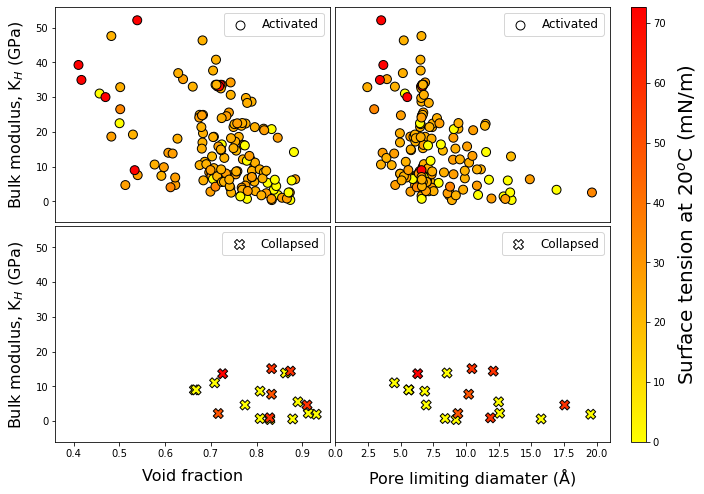

In [18]:
#cm = plt.cm.gist_rainbow
cm = plt.cm.autumn_r
#cm = plt.cm.gnuplot_r

fig, ax = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(10,8))
plt.subplots_adjust(wspace=0.02, hspace=0.02, left= 0.08)
fig.subplots_adjust(right = 0.85)


#--------------------------------------------------------------------------------------------------------------------#

X = activated_last_solvent['AV_VF']
Y = activated_last_solvent['K']
Z = activated_last_solvent['tension']

pp=ax[0,0].scatter(x=X, y=Y, c=Z, vmin=min(Z), vmax=max(Z), cmap=cm, s =80, alpha = 1.0, edgecolor ='k', label = "Activated")
ax[0,0].legend(loc ='upper right', fontsize = 12)
ax[0,0].set_ylabel("Bulk modulus, K${_H}$ (GPa)", fontsize = 16, labelpad=10)

ax[0,0].axis([0.36, 0.96, -6, 56])

#--------------------------------------------------------------------------------------------------------------------#

X = activated_last_solvent['PLD']
Y = activated_last_solvent['K']
Z = activated_last_solvent['tension']

ax[0,1].scatter(x=X, y=Y, c=Z, vmin=min(Z), vmax=max(Z), cmap=cm, s =80, alpha = 1.0, edgecolor ='k', label = "Activated")
ax[0,1].legend(loc ='upper right', fontsize = 12)
ax[0,1].axis([0, 21, -6, 56])

#--------------------------------------------------------------------------------------------------------------------#

X = collapsed_last_solvent['AV_VF']
Y = collapsed_last_solvent['K']
Z = collapsed_last_solvent['tension']

ax[1,0].scatter(x=X, y=Y, c=Z, vmin=min(Z), vmax=max(Z), cmap=cm, marker ='X', s =100, alpha = 1.0, edgecolor ='k', label = "Collapsed")
ax[1,0].legend(loc ='upper right', fontsize = 12)
ax[1,0].set_xlabel("Void fraction", fontsize = 16, labelpad=10)
ax[1,0].set_ylabel("Bulk modulus, K${_H}$ (GPa)", fontsize = 16, labelpad=10)

ax[1,0].axis([0.36, 0.96, -6, 56])
#--------------------------------------------------------------------------------------------------------------------#

X = collapsed_last_solvent['PLD']
Y = collapsed_last_solvent['K']
Z = collapsed_last_solvent['tension']

ax[1,1].scatter(x=X, y=Y, c=Z, vmin=min(Z), vmax=max(Z), cmap=cm, marker ='X', s =100, alpha = 1.0, edgecolor ='k', label = "Collapsed")
ax[1,1].legend(loc ='upper right', fontsize = 12)
ax[1,1].set_xlabel("Pore limiting diamater (Å)", fontsize = 16, labelpad=10)
ax[1,1].axis([0.0, 21, -6, 56])

#------------------------- color bar ---------------------------------#
cb_ax = fig.add_axes([0.88, 0.125, 0.02, 0.755])
cbar = fig.colorbar(pp, cax=cb_ax)
cbar.set_label(label='Surface tension at 20$^o$C (mN/m)', size=20, labelpad=10)
#---------------------------------axsis------------------------------#
ax[0,0].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_xticks([])
ax[1,1].set_yticks([])
#------------------------------- ligand -------------------------------#
leg = ax[0,0].get_legend()
leg.legendHandles[0].set_facecolor('w')
leg = ax[0,1].get_legend()
leg.legendHandles[0].set_facecolor('w')
leg = ax[1,0].get_legend()
leg.legendHandles[0].set_facecolor('w')
leg = ax[1,1].get_legend()
leg.legendHandles[0].set_facecolor('w')

#plt.tight_layout()
plt.savefig("Last solvent - surface tension.png", dpi=200)

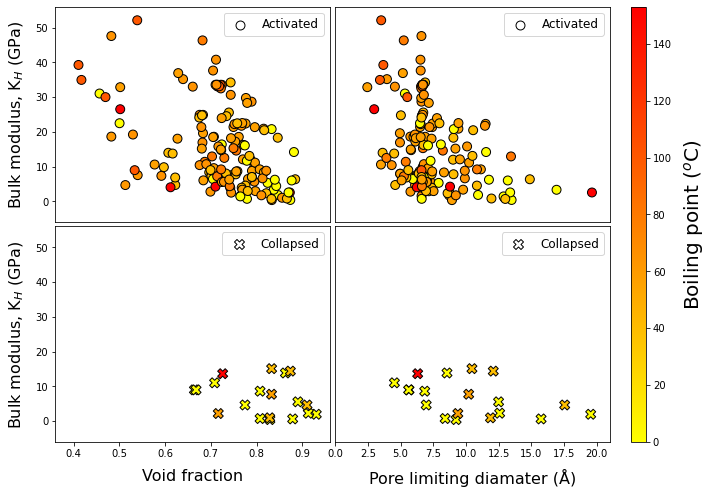

In [19]:
#cm = plt.cm.gist_rainbow
cm = plt.cm.autumn_r
#cm = plt.cm.gnuplot_r

fig, ax = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(10,8))
plt.subplots_adjust(wspace=0.02, hspace=0.02, left= 0.08)
fig.subplots_adjust(right = 0.85)


#--------------------------------------------------------------------------------------------------------------------#

X = activated_last_solvent['AV_VF']
Y = activated_last_solvent['K']
Z = activated_last_solvent['boiling']

pp=ax[0,0].scatter(x=X, y=Y, c=Z, vmin=min(Z), vmax=max(Z), cmap=cm, s =80, alpha = 1.0, edgecolor ='k', label = "Activated")
ax[0,0].legend(loc ='upper right', fontsize = 12)
ax[0,0].set_ylabel("Bulk modulus, K${_H}$ (GPa)", fontsize = 16, labelpad=10)

ax[0,0].axis([0.36, 0.96, -6, 56])

#--------------------------------------------------------------------------------------------------------------------#

X = activated_last_solvent['PLD']
Y = activated_last_solvent['K']
Z = activated_last_solvent['boiling']

ax[0,1].scatter(x=X, y=Y, c=Z, vmin=min(Z), vmax=max(Z), cmap=cm, s =80, alpha = 1.0, edgecolor ='k', label = "Activated")
ax[0,1].legend(loc ='upper right', fontsize = 12)
ax[0,1].axis([0, 21, -6, 56])

#--------------------------------------------------------------------------------------------------------------------#

X = collapsed_last_solvent['AV_VF']
Y = collapsed_last_solvent['K']
Z = collapsed_last_solvent['boiling']

ax[1,0].scatter(x=X, y=Y, c=Z, vmin=min(Z), vmax=max(Z), cmap=cm, marker ='X', s =100, alpha = 1.0, edgecolor ='k', label = "Collapsed")
ax[1,0].legend(loc ='upper right', fontsize = 12)
ax[1,0].set_xlabel("Void fraction", fontsize = 16, labelpad=10)
ax[1,0].set_ylabel("Bulk modulus, K${_H}$ (GPa)", fontsize = 16, labelpad=10)

ax[1,0].axis([0.36, 0.96, -6, 56])
#--------------------------------------------------------------------------------------------------------------------#

X = collapsed_last_solvent['PLD']
Y = collapsed_last_solvent['K']
Z = collapsed_last_solvent['boiling']

ax[1,1].scatter(x=X, y=Y, c=Z, vmin=min(Z), vmax=max(Z), cmap=cm, marker ='X', s =100, alpha = 1.0, edgecolor ='k', label = "Collapsed")
ax[1,1].legend(loc ='upper right', fontsize = 12)
ax[1,1].set_xlabel("Pore limiting diamater (Å)", fontsize = 16, labelpad=10)
ax[1,1].axis([0.0, 21, -6, 56])

#------------------------- color bar ---------------------------------#
cb_ax = fig.add_axes([0.88, 0.125, 0.02, 0.755])
cbar = fig.colorbar(pp, cax=cb_ax)
cbar.set_label(label='Boiling point ($^o$C)', size=20, labelpad=10)
#---------------------------------axsis------------------------------#
ax[0,0].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_xticks([])
ax[1,1].set_yticks([])
#------------------------------- ligand -------------------------------#
leg = ax[0,0].get_legend()
leg.legendHandles[0].set_facecolor('w')
leg = ax[0,1].get_legend()
leg.legendHandles[0].set_facecolor('w')
leg = ax[1,0].get_legend()
leg.legendHandles[0].set_facecolor('w')
leg = ax[1,1].get_legend()
leg.legendHandles[0].set_facecolor('w')

#plt.tight_layout()
plt.savefig("Last solvent - boiling.png", dpi=200)